<a href="https://colab.research.google.com/github/Leothorn/EVA8/blob/main/EVA8__Assignment_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import random
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import copy
torch.set_printoptions(linewidth=120)


In [15]:
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

modified_train_set = copy.deepcopy(train_set)
modified_test_set  = copy.deepcopy(test_set)

# Create the modified train set which adds a random number to the training and testing dataset
modified_train_set = [(record[0], record[1], (x := random.randint(0, 9)), record[1] + x) for record in modified_train_set]
modified_test_set = [(record[0], record[1], (x := random.randint(0, 9)), record[1] + x) for record in modified_test_set]




In [16]:
sample = iter(modified_train_set) #Initialize iterator on the modified trainset

5 9 14


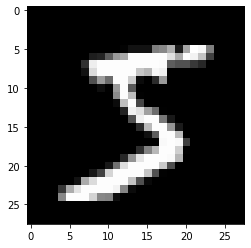

In [17]:
(img,label,random_int,total)=next(sample)
plt.imshow(img.squeeze(), cmap='gray')
print(label,random_int,total)

In [18]:
batchsize = 32  # This modified batch has a batch size of 32

train_loader = torch.utils.data.DataLoader(modified_train_set, batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(modified_test_set, batch_size=batchsize)

In [19]:
sample = iter(train_loader)
(img,label,random_int,total)=next(sample)

labels: tensor([4, 8, 5, 2, 2, 5, 2, 9, 2, 4, 7, 6, 1, 6, 7, 8, 7, 7, 4, 4, 1, 1, 1, 2, 8, 4, 3, 0, 1, 9, 2, 6])
random_int tensor([3, 7, 3, 8, 7, 9, 6, 7, 3, 7, 8, 8, 4, 8, 7, 0, 6, 6, 2, 1, 4, 4, 0, 2, 9, 2, 4, 6, 9, 3, 4, 5])
total tensor([ 7, 15,  8, 10,  9, 14,  8, 16,  5, 11, 15, 14,  5, 14, 14,  8, 13, 13,  6,  5,  5,  5,  1,  4, 17,  6,  7,  6,
        10, 12,  6, 11])


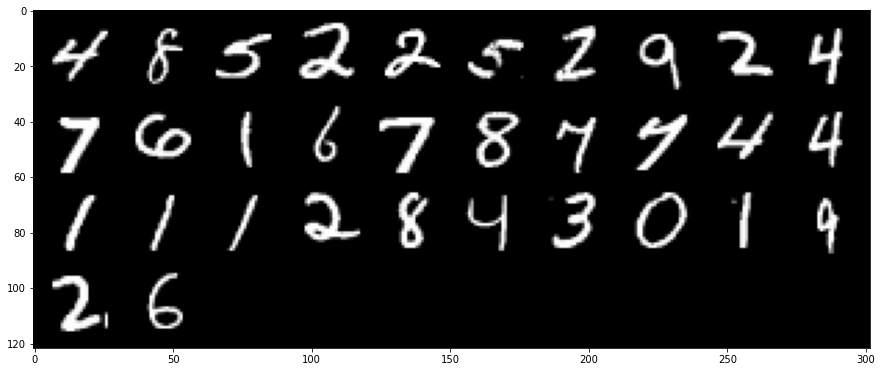

In [20]:
grid = torchvision.utils.make_grid(img, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', label)
print('random_int',random_int)
print('total',total)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define model layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
        self.fc2 = nn.Linear(10, 32)  # change the output size of fc2 to 32
        self.fc3 = nn.Linear(32, 18)  # add a fully-connected layer with 18 output neurons

    def forward(self,x,y):
        # Define the forward pass of the model
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        return x
        # One-hot encode y and concatenate to x
        y_one_hot = F.one_hot(y, num_classes=10)
        x = torch.cat((x, y_one_hot), dim=1)
        # Pass x through the fully-connected layer fc2 and fc3        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x


# Initialize the model and define the loss function and optimizer
model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Define the number of epochs to train for
num_epochs = 2

# Train the model
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    # Loop over the train_loader
    for i, (inputs, labels, random_ints, total) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(inputs,random_ints)
        # Compute the loss
        loss = loss_fn(output,labels,total)
        # Backward pass
        loss.backward()
        # Update the parameters
        optimizer.step()
    # Set the model to evaluation mode
    model.eval()
    # Initialize some metric variables
    total_loss = 0
    num_correct = 0
    num_samples = 0
    # Loop over the test_loader
    with torch.no_grad():
        for i, (inputs, labels, random_ints, total) in enumerate(test_loader):
            # Forward pass
            output = model(inputs,random_ints)
            # Compute the loss
            loss = loss_fn(output, labels)
            total_loss += loss.item()
            # Compute the accuracy
            _, preds = output.max(dim=1)
            num_correct += (preds == labels).sum().item()
            num_samples += inputs.size(0)

    # Print the epoch loss and accuracy
    print(f'Epoch {epoch+1}: Loss = {total_loss/len(test_loader):.4f}, Accuracy = {num_correct/num_samples:.4f}')


Epoch 1: Loss = 0.1873, Accuracy = 0.9468
Epoch 2: Loss = 0.1163, Accuracy = 0.9644
Epoch 3: Loss = 0.0867, Accuracy = 0.9728
Epoch 4: Loss = 0.0786, Accuracy = 0.9751
Epoch 5: Loss = 0.0702, Accuracy = 0.9769
Epoch 6: Loss = 0.0609, Accuracy = 0.9804
Epoch 7: Loss = 0.0702, Accuracy = 0.9775
Epoch 8: Loss = 0.0484, Accuracy = 0.9829
Epoch 9: Loss = 0.0478, Accuracy = 0.9830
Epoch 10: Loss = 0.0478, Accuracy = 0.9839
